# COSMOS2020 - cosmic web

## Initialization

In [1]:
%run myPackages.py
import filament_functions as func
# %run filaments_variables.py
%matplotlib inline 

#########################################################################
################## Cosmological/Physical Parameters #####################
#########################################################################

c0 = 3e5
H_0 = 70
Omega_l = 0.7
Omega_m = 0.3

z_min = 0.4
z_max = 6

lim_deltaz = 2
Ks_cut = 24.5

cosmo = FlatLambdaCDM(H0 = H_0, Om0 = Omega_m)

#########################################################################
############################# Directories ###############################
#########################################################################

cat_dir = "/Users/sinataamoli/Desktop/COSMOS/COSMOS2020_catalog/"
LSS_dir = "/Users/sinataamoli/Desktop/COSMOS/COSMOS2020_LSS/"
filament_dir = "/Users/sinataamoli/Desktop/COSMOS/COSMOS2020_FILAMENTS/"

outputs_dir, plots_dir, eigenvalues_dir, signals_dir, inputs_dir = func.setup()
#########################################################################
############################# Import Data ###############################
#########################################################################

# %run import_COSMOS2020.py

# Data = Table(Data)
# Data.write(cat_dir + 'Data_magLimit245_Taamoli24.fits', overwrite=True)

Data = Table.read(cat_dir + 'Data_magLimit245_Taamoli24.fits')
delta_z = np.array(Data['lp_zPDF_u68'] - Data['lp_zPDF_l68'])


#########################################################################
############################# z slices ##################################
#########################################################################

physical_width = 35 # h^-1 Mpc

slice_centers, z_edges = func.redshift_bins(z_min, z_max, physical_width)

z_width = z_edges[:, 1] - z_edges[:, 0]

#########################################################################
############################# Covered Area ##############################
#########################################################################

alpha_min, alpha_max, delta_min, delta_max = 149.397, 150.786, 1.603, 2.816

height = delta_max - delta_min
width = alpha_max - alpha_min
field_area = height * width
holes_area = 0.211 * (height * width) 
corrected_area = field_area - holes_area

wh_ratio = width / height

# circles = np.load('inputs/circles.npy')
circles = np.load(LSS_dir+'inputs/circles_unmasked.npy')

#########################################################################
############################# Weights ###################################
#########################################################################
weight_threshold = 0.05

weights_block = np.load(LSS_dir + 'inputs/WeightsBlock_magcut245.npy')
W = np.load(LSS_dir + 'inputs/WeightsBlock-magcut245-W-th05-normalized.npy')
ind = np.array([np.where(weights_block > weight_threshold)[0], np.where(weights_block > weight_threshold)[1]]).T

gals_bin = []
for i in range(0, len(slice_centers)):
    gals_bin.append(np.unique(ind[ind[:, 1] == i, 0]))
    
inds_th = []
for i in range(0, len(slice_centers)):
    inds_th.append(np.where(weights_block[:, i] >= weight_threshold)[0])


print('\n length of Data:')
print(len(Data))
print('\n Covered Area:')
print('alpha_min-alpha_max: %.3f - %.3f | delta_min-delta_max: %.3f - %.3f \n' %(alpha_min, alpha_max, delta_min, delta_max))
print('height: %.3f - width: %.3f - masked regions: %d' %(height, width, len(circles)))

/opt/anaconda3/envs/filaments/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


all packages are now imported!
all packages are now imported!

 length of Data:
211431

 Covered Area:
alpha_min-alpha_max: 149.397 - 150.786 | delta_min-delta_max: 1.603 - 2.816 

height: 1.213 - width: 1.389 - masked regions: 7598


## Filament Finders

### Multi-Scale Morphology Filter (MMF)- Aragon-Calvo et al. 2007

\begin{equation}
    H_{L} (r) = \int dr' \, \Sigma(r') \frac{(x_{i} - x'_{i})(x_{j} - x'_{j}) - \delta_{ij}L^{2}}{L^{4}}G_{L}(r', r)
\end{equation}

\begin{equation}
G_{L}(r', r) = \frac{1}{2 \pi L^{2}}exp ( - \frac{|r' - r|^{2}}{2L^{2}})
\end{equation}

In [2]:
class Slice:
    """
    A redshift Slice is an instance of this Class!
    
    """
    alpha_min, alpha_max, delta_min, delta_max = 149.397, 150.786, 1.603, 2.816
    
    def __init__(self, slice_no):
        # slice number: starting from 0
        self.No = slice_no
        self.width = z_width[self.No]
        self.center = slice_centers[self.No]
        self.density = np.load(LSS_dir + 'Densities/density_slice%d_z=%.3f_b=LCV.npy' 
                                             %(self.No, slice_centers[self.No]))
        self.density_contrast = np.load(LSS_dir + 'Densities/densityContrast_Slice%d_z=%.3f_b=LCV.npy' 
                                                %(self.No, slice_centers[self.No]))
        self.density_excess = np.load(LSS_dir + 'Densities/densityExcess_Slice%d_z=%.3f_b=LCV.npy' 
                                                %(self.No, slice_centers[self.No]))
        sources = np.load(LSS_dir + 'Densities/pts_10col_slice%d_z=%.3f_b=LCV.npy' %(self.No, slice_centers[self.No]))
        self.sources = pd.DataFrame(sources, columns = ['ra', 'dec', 'w', 'bi',
                                         'B.C', 'ind_slice', 'ID', 'sigma', 'del', 'sigma*w'])
        self.sources = self.sources.astype({'ID':'int'})
        self.sources = self.sources.astype({'ind_slice':'int'})
    
        self.field_rows, self.field_cols = self.density_contrast.shape

        
    # def calculate_density(self, mesh_y = 120, edge = 0.05):
    #     COL_pts = 10
    #     Global_b = np.load(LSS_dir + 'inputs/ks245/Global_b_LCV.npy')
    #     b = Global_b[self.No]

    #     sliceNo = self.No
    #     ind_slice = inds_th[sliceNo]
    #     d = Data[ind_slice]
    #     w = W[ind_slice, sliceNo]

    #     n_dens = len(d) / corrected_area

    #     N_y = int(np.sqrt(n_dens * field_area / wh_ratio))
    #     N_x = int(wh_ratio * N_y)

    #     x_fill = np.linspace(alpha_min, alpha_max, N_x)
    #     y_fill = np.linspace(delta_min, delta_max, N_y)
    #     num_of_points = N_x * N_y

    #     x_fill, y_fill = np.meshgrid(x_fill, y_fill)

    #     grid = np.zeros((num_of_points, COL_pts))
    #     grid[:, 0] = np.vstack([x_fill.ravel(), y_fill.ravel()]).T[:, 0]
    #     grid[:, 1] = np.vstack([x_fill.ravel(), y_fill.ravel()]).T[:, 1]

    #     xy = np.array((grid[:, 0], grid[:, 1]))

    #     for i in range(len(circles)):
    #         ind = plt.Circle((circles[i, 0], circles[i, 1]), circles[i, 2]).contains_points(xy.T)
    #         ii = np.where(ind == True)[0]
    #         grid[ii, 2] = 1

    #     filled_holes = grid[grid[:, 2] == 1]

    #     avg_w = np.full(len(filled_holes), (np.sum(w) / len(d)))

    #     p = np.zeros((len(d), COL_pts))

    #     p[:, 0] = d['ALPHA_J2000']            
    #     p[:, 1] = d['DELTA_J2000']            
    #     p[:, 2] = w
    #     p[:, 5] = ind_slice

    #     fp = np.zeros((len(filled_holes), COL_pts))
    #     fp[:, 0] = filled_holes[:, 0]   
    #     fp[:, 1] = filled_holes[:, 1]   
    #     fp[:, 2] = avg_w[:]             

    #     # pts[:, 0]: alpha
    #     # pts[:, 1]: delta
    #     # pts[:, 2]: weight
    #     # pts[:, 3]: adaptive bandwidth
    #     # pts[:, 4]: boundary correction factor
    #     # pts[:, 5]: ind_slice
    #     # pts[:, 6]: Catalog ID
    #     # pts[:, 7]: calculated density
    #     # pts[:, 8]: density contrast
    #     # pts[:, 9]: density (sigma) * weight


    #     pts = np.concatenate((p, fp))
    #     pts[:, 4] = 1

    #     pts = pts[(pts[:, 0] < alpha_max) & (pts[:, 0] > alpha_min)]
    #     pts = pts[(pts[:, 1] < delta_max) & (pts[:, 1] > delta_min)]

    #     Boundaries_ind = np.where((pts[:, 0] < (alpha_min + edge) ) | ((alpha_max - edge) < pts[:, 0])
    #         | (pts[:, 1] < (delta_min + edge)) | ((delta_max - edge) < pts[:, 1]))

    #     for i in range(len(Boundaries_ind[0])):
    #         f = lambda delta, alpha: np.exp(-((delta-pts[Boundaries_ind[0][i], 1])**2 + (alpha-pts[Boundaries_ind[0][i], 0])**2) / (2 * b**2))
    #         integral = integrate.dblquad(f, alpha_min, alpha_max, lambda alpha: delta_min, lambda alpha: delta_max)[0]
    #         pts[Boundaries_ind[0][i], 4] = (2 * np.pi * b**2) / integral

    #     bi = Adaptive_b(b, pts)
    #     pts[:, 3] = bi

    #     mesh_y = 120
    #     mesh_x = int(wh_ratio * mesh_y)

    #     gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    #     gr_y = np.linspace(delta_min, delta_max, mesh_y)

    #     grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    #     density = np.zeros((mesh_y , mesh_x))

    #     for i in range(0, mesh_x):
    #         for j in range(0, mesh_y):
    #             density[j, i] = func.σ(gr_x[i], gr_y[j], bi, pts)

    #     bg_density = np.median(density)

    #     density_contrast = density / bg_density - 1
    #     density_excess = density / bg_density

    #     pts[0:len(d), 6] = Data[ind_slice]['ID']

    #     for i in range(0, len(d)):
    #         pts[i, 7] = func.σ(pts[i, 0], pts[i, 1], pts[i, 3], pts) * pts[i, 4]

    #     pts[0:len(d), 8] = (pts[0:len(d), 7] / bg_density[sliceNo]) -1
    #     pts[0:len(d), 9] = pts[0:len(d), 2] * pts[0:len(d), 7]

    #     np.save(output_dir + 'Densities_v2/pts_10col_slice%d_z=%.3f_b=%d kpc.npy' %(sliceNo, slice_centers[sliceNo], B_kpc), pts)
    #     np.save(output_dir + 'Densities_v2/density_slice%d_z=%.3f_b=%d kpc.npy' %(sliceNo, slice_centers[sliceNo], B_kpc), density)
    #     np.save(output_dir + 'Densities_v2/densityContrast_Slice%d_z=%.3f_b=%d kpc.npy' %(sliceNo, slice_centers[sliceNo], B_kpc), density_contrast)
    #     np.save(output_dir + 'Densities_v2/densityExcess_Slice%d_z=%.3f_b=%d kpc.npy' %(sliceNo, slice_centers[sliceNo], B_kpc), density_excess)


    def plot(self, to_be_plotted = 'density', vmin_user = 'default', vmax_user = 'default', normal = 'none', cmap = 'jet'):
        
        if to_be_plotted not in ['density', 'density_contrast', 'density_excess']:
            raise ValueError("Invalid argument: ['density', 'density_contrast', 'density_excess']")


        elif to_be_plotted == 'density':
            field = self.density
            title = 'Density Field'
            cbar_title = 'surface density ($\sigma$)'

        elif to_be_plotted == 'density_contrast':
            field = self.density_contrast
            title = 'Density Contrast'
            cbar_title = 'density contrast ($\delta$)'

        elif to_be_plotted == 'density_excess':
            field = self.density_excess
            title = 'Density Excess'
            cbar_title = 'density enhancement ($1+\delta$)'

        rows, columns = 1, 1
        fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (10, 7))

        # Plot Settings
        axlabelsize = 24
        ticklabelsize = 20
        titlesize = 22
        cbarlabelsize1 = 21
        markerSize = 3
        scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[self.No]).value * 10000 / 3600
        cmap1 = plt.cm.get_cmap('bone_r')

        mesh_y, mesh_x = np.shape(field)
        gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
        gr_y = np.linspace(delta_min, delta_max, mesh_y)
        grid_x, grid_y = np.meshgrid(gr_x, gr_y)

        ax.set_xlabel('R.A [deg.]', size = axlabelsize)
        ax.set_ylabel('dec [deg.]', size = axlabelsize)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
        ax.set_xlim(150.85, 149.35)
        ax.set_ylim(1.55, 2.86)
        ax.set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
        ax.set_xticks([149.4, 149.6, 149.8, 150, 150.2, 150.4, 150.6, 150.8])
        ax.set_yticklabels(ax.get_yticks(), fontsize = ticklabelsize)
        ax.set_xticklabels(ax.get_xticks(), fontsize = ticklabelsize)
        ax.xaxis.set_minor_locator(MultipleLocator(0.02))
        ax.yaxis.set_minor_locator(MultipleLocator(0.02))
        ax.tick_params(which='major', width=2, length = 8)
        ax.tick_params(which='minor', width=1, length = 5)
        ax.set_title(title + ' - z = %.3f' %slice_centers[self.No], size = titlesize, pad = 15)

        if normal == 'max':
            field = field / np.max(field)
            vmin_, vmax_ = 0, 1
        elif isinstance(normal, (int, float)):
            field = field / normal
            vmin_, vmax_ = 0, 1
        elif (vmin_user == 'default') and (vmax_user == 'default'): 
            vmin_, vmax_ = np.min(field), np.max(field)
        else:
            vmin_, vmax_ = vmin_user, vmax_user

        densityMap = ax.contourf(grid_x, grid_y, field, 150, cmap=cmap, vmin = vmin_, vmax = vmax_)
        ax.contour(grid_x, grid_y, self.density, levels = 2)
        
        cb0 = fig.colorbar(densityMap, ax = ax)
        cb0.set_label(cbar_title, size = cbarlabelsize1, labelpad = 14)
        cb0.ax.tick_params(axis='both', which='major', labelsize = ticklabelsize)

        ax.hlines(2.7, 149.47, 149.47 + scale_bar, lw = 5, color = 'white')
        ax.text(149.68, 2.73, '10 Mpc', size = 23, color = 'white',bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))

/var/folders/ry/7h2qkbms38q458j803wlq8c80000gp/T/ipykernel_35400/3483680558.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap('bone_r')


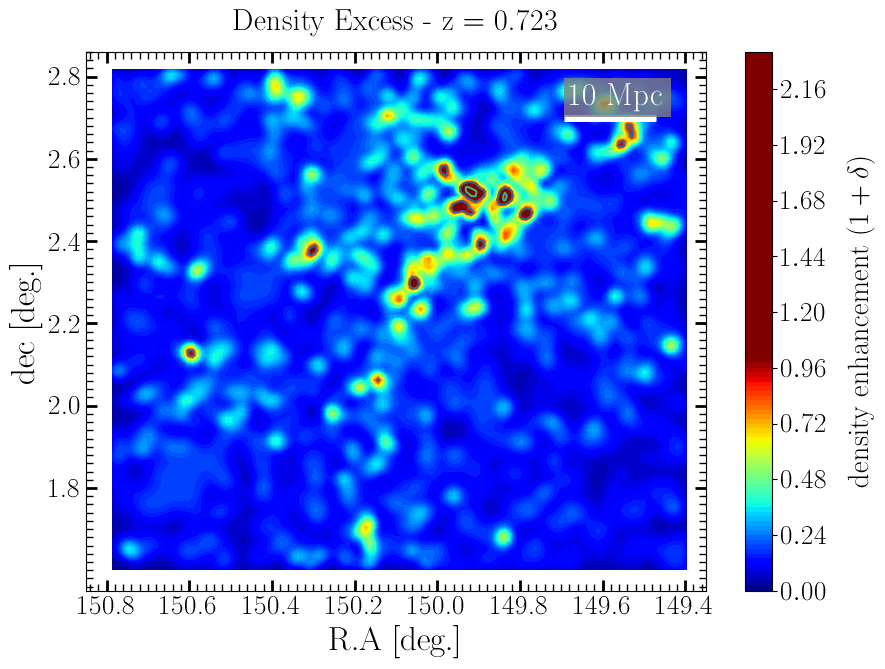

In [13]:
slice_no = 20
field = Slice(slice_no).density_excess
Slice(slice_no).plot('density_excess', normal = 6.5)

The scale-space MMF analysis described in this study involves a discrete number of N+1 levels, n = 0,..., N. Following
Sato et al. (1998) we use a nested hierarchy of filters having
widths differing by a factor of $\sqrt{2}$: <br>
$R_{n} = (\sqrt{2})^{n}R_{0}$ <br>

In order to properly compare the values of the Hessian arising from the differently scaled variants of the data that make up
the Scale Space we must use a renormalised Hessian: <br>

$H = R^{2}_{s}H$ <br>

where RS is the filter width that has been used ($\sqrt{2^{n}}$ for level n in our case). Instead of using this “natural” renormalization, it would be possible to use a scaling factor $R^{2\gamma}$. Using values $\gamma > 1$ will give a bias towards finding larger structures, while values $\gamma < 1$ will give a bias towards finding smaller structures.


In [19]:
scales_ordered = []
R_0 = 0.5
for n in range(6):
    scales_ordered.append(R_0 * (2**(n/2)))
scales_ordered

[0.5, 0.7071067811865476, 1.0, 1.4142135623730951, 2.0, 2.8284271247461903]

In [ ]:
## Parallelization
# slice_no = 75
# scales_Mpc = [0.5, 1.5]
# gr_x = np.linspace(alpha_min, alpha_max, num_cols)
# gr_y = np.linspace(delta_min, delta_max, num_rows)

# distance_scale_x = gr_x[1] - gr_x[0]
# distance_scale_y = gr_y[1] - gr_y[0]

# args = [(slice_no, scale) for scale in scales_Mpc]
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     results = list(executor.map(lambda p: pre_hessian(*p), args))

In [14]:
def gaussian_kernel(x, y, x_prime, y_prime, L, distance_scale_x, distance_scale_y):
    distance_squared = ((x - x_prime) * distance_scale_x)**2 + ((y - y_prime) * distance_scale_y)**2
    exponent = -distance_squared / (2 * L**2)
    return np.exp(exponent) / (2 * np.pi * L**2)

def pre_hessian(slice, scales,  distance_scale_x, distance_scale_y, box_size = 100, threshold_L = 0.05, num_rows = 120, num_cols = 137, save_dir = './inputs/pre/diff'):
    redshift = slice_centers[slice]
    for L in scales:
        gaussian_kernel_path = os.path.join(save_dir, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L))
        L_deg = cosmo.arcsec_per_kpc_comoving(redshift).value * L / 3.6

        if L_deg > threshold_L: 
            half_box_size = box_size / 2
        else:
            half_box_size = box_size / 4

        # Kernel tensor
        if not os.path.exists(gaussian_kernel_path):
            print('Calculating kernel tensor for L = %.2f Mpc at slice %d ...' %(L, slice))
            gauss_tensor = np.zeros((num_rows, num_cols, num_rows, num_cols))
            for i in tqdm(range(0, num_rows)):
                for j in range(num_cols):
                    min_row = int(max(0, i - half_box_size))
                    max_row = int(min(num_rows, i + half_box_size + 1))
                    min_col = int(max(0, j - half_box_size))
                    max_col = int(min(num_cols, j + half_box_size + 1))
                    for m in range(min_row, max_row):
                        for n in range(min_col, max_col):
                            gauss_tensor[i, j, m, n] = gaussian_kernel(i, j, m, n, L_deg, distance_scale_x, distance_scale_y)
            np.save(os.path.join(save_dir, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L)), gauss_tensor)

        # Shape tensor
        shape_path = os.path.join(save_dir, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L))
        if not os.path.exists(shape_path):
            print('Calculating shape tensor for L = %.2f Mpc at slice %d ...' %(L, slice))
            shape_tensor = np.zeros((num_rows, num_cols, num_rows, num_cols, 2, 2))
            for i in tqdm(range(0, num_rows)):
                for j in range(num_cols):
                    min_row = int(max(0, i - half_box_size))
                    max_row = int(min(num_rows, i + half_box_size + 1))
                    min_col = int(max(0, j - half_box_size))
                    max_col = int(min(num_cols, j + half_box_size + 1))
                    for m in range(min_row, max_row):
                        for n in range(min_col, max_col):
                            sub_shape = np.zeros((2, 2))

                            sub_shape[0, 0] = (((m - i) * distance_scale_x)**2 - L_deg**2) / (L_deg**4)
                            sub_shape[0, 1] = ((i - m) * (j - n) * distance_scale_x * distance_scale_y) / (L_deg**4)
                            sub_shape[1, 0] = ((i - m) * (j - n) * distance_scale_x * distance_scale_y) / (L_deg**4)
                            sub_shape[1, 1] = (((n - j) * distance_scale_y)**2 - L_deg**2) / (L_deg**4)

                            shape_tensor[i, j, m, n] = sub_shape
            np.save(os.path.join(save_dir, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L)), shape_tensor) 

def hessian_eigenvalues(slice, L_Mpc, num_rows = 120, num_cols = 137, gamma = 1, path = './outputs/eigenvalues', inputs_dir = './inputs'):
    field = Slice(slice).density_excess
    L = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * L_Mpc / 3.6
    eigenvalues_field = np.empty((num_rows, num_cols), dtype=object)

    pre_path = os.path.join(inputs_dir, 'pre/diff')
    shape_path = os.path.join(pre_path, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L_Mpc))
    Gaussian_kernel_path = os.path.join(pre_path, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L_Mpc))
    out_path_eigen = os.path.join(path, 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], L_Mpc, gamma))

    if not os.path.exists(out_path_eigen):
        print('Calculating eigenvalues for L = %.2f Mpc at slice %d ...' %(L_Mpc, slice))
        shape = np.load(shape_path, allow_pickle = True)
        Gaussian_kernel = np.load(Gaussian_kernel_path, allow_pickle = True)
        
        for i in range(0, num_rows):
            for j in range(num_cols):
                hessian = np.zeros((2, 2))
                weight = Gaussian_kernel[i, j]
                hessian[0, 0] = np.sum(weight * field * shape[i, j, :, :, 0, 0])
                hessian[0, 1] = np.sum(weight * field * shape[i, j, :, :, 0, 1])
                hessian[1, 0] = np.sum(weight * field * shape[i, j, :, :, 1, 0])
                hessian[1, 1] = np.sum(weight * field * shape[i, j, :, :, 1, 1])

                normalized_hessian = (L ** gamma) * hessian                    
                eigenvalues = np.linalg.eigvals(hessian)            
                eigenvalues_field[i, j] = eigenvalues.tolist()

        np.save(out_path_eigen, eigenvalues_field)
        return eigenvalues_field
    else:
        print('Eigenvalues for L = %.2f Mpc at slice %d already exist.' %(L_Mpc, slice))
        print(out_path_eigen)

def max_signal(slice, num_rows = 120, num_cols = 137, beta = 0.5, sensitivity_factor = 0.5, gamma = 1, eigenvalues_path = './outputs/eigenvalues', output_dir = 'outputs'):

    files = glob.glob(os.path.join(eigenvalues_dir, 'ev_slice%d_z=%.3f_L=*.npy' %(slice, slice_centers[slice])))
    scales_mpc = np.sort(np.array([x.split(os.sep)[-1].split('_')[3] for x in files]))
    print('Exsisting scales for slice %d: ' %slice, scales_mpc)
    scales_mpc = np.array([x.split(' ')[0] for x in scales_mpc])
    scales_mpc = np.array([x.split('=')[1] for x in scales_mpc]).astype(float)

    # Cluster/Filament Signals

    cluster_signal = {}
    filament_signal = {}

    for scale in scales_mpc: 
        cluster_keyName = f"{scale} Mpc"
        filament_keyName = f"{scale} Mpc"
        
        # First and Second Eigenvalue
        eigenval_path = os.path.join(eigenvalues_dir , 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], scale, gamma))
        eigens = np.load(eigenval_path, allow_pickle=True)
        lambda_1 = np.zeros((num_rows, num_cols))
        lambda_2 = np.zeros((num_rows, num_cols))

        # Norm of the Hessian Matrix
        I = np.zeros((num_rows, num_cols))
        Norm = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                lambda_1[i, j] = eigens[i, j][0]
                lambda_2[i, j] = eigens[i, j][1]
                Norm[i, j] = np.sqrt(lambda_1[i, j]**2 + lambda_2[i, j]**2)

        c_sensitivity = sensitivity_factor * np.max(Norm)

        for i in range(num_rows):
            for j in range(num_cols):
                I[i, j] = 1 - np.exp(- (Norm[i, j]**2) / (2 * (c_sensitivity**2)))

        # Morphology Mask

        eps_cluster = np.ones((num_rows, num_cols))
        eps_filament = np.ones((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]
            
                if (lam_1 > 0) or (lam_2 > 0):
                    eps_cluster[i, j] = 0

                if (lam_2 > 0):
                    eps_filament[i, j] = 0

        # Degree of Resemblence

        D_cluster = np.zeros((num_rows, num_cols))
        D_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]

                if (eps_cluster[i, j] == 1):
                    D_cluster[i, j] = abs(lam_1) / abs(lam_2)

                if (eps_filament[i, j] == 1):
                    D_filament[i, j] = 1 - (abs(lam_1) / abs(lam_2))

        # Feature selector M

        M_cluster = np.zeros((num_rows, num_cols))
        M_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                if (eps_cluster[i, j] == 1):
                    M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                if (eps_filament[i, j] == 1):
                    M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

        # Cluster/Filament signal S

        Signal_cluster = np.zeros((num_rows, num_cols))
        Signal_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                # M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

                Signal_cluster[i, j] = eps_cluster[i, j] * M_cluster[i, j] * I[i, j]
                Signal_filament[i, j] = eps_filament[i, j] * M_filament[i, j] * I[i, j]
        
        Signal_cluster = tuple(Signal_cluster)
        Signal_filament = tuple(Signal_filament)

        cluster_signal[cluster_keyName] = Signal_cluster
        filament_signal[filament_keyName] = Signal_filament

    max_signal_cluster = np.zeros((num_rows, num_cols))
    max_signal_filament = np.zeros((num_rows, num_cols))

    for key, array in cluster_signal.items():
        max_signal_cluster = np.maximum(max_signal_cluster, cluster_signal[key])

    for key, array in filament_signal.items():
        max_signal_filament = np.maximum(max_signal_filament, filament_signal[key])

    np.save(os.path.join(signals_dir,'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice],gamma)), max_signal_cluster)
    np.save(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)), max_signal_filament)
    return max_signal_cluster, max_signal_filament

def web_extractor(slices, scales_Mpc, distance_scale_x, distance_scale_y, num_rows = 120, num_cols = 137, gamma = 1, beta = 0.5, sensitivity_factor = 0.5):
    for slice in slices:
        pre_hessian(slice, scales_Mpc,  distance_scale_x, distance_scale_y)
        print(f"Kernel/Differentiation tensors are ready for slice %d ..." %slice)
        for scale in scales_Mpc:
            print("Eigenvalues for scale %.2f Mpc ..." %scale)
            hessian_eigenvalues(slice, scale)
        
        max_signal_cluster, max_signal_filament = max_signal(slice)
    return max_signal_cluster, max_signal_filament


In [15]:
redshift_slices = [20]
scales_Mpc = [0.5, 0.7, 1, 1.5, 2, 3, 4]

num_rows, num_cols = 120, 137

gr_x = np.linspace(alpha_min, alpha_max, num_cols)
gr_y = np.linspace(delta_min, delta_max, num_rows)

distance_scale_x = gr_x[1] - gr_x[0]
distance_scale_y = gr_y[1] - gr_y[0]

max_signal_cluster, max_signal_filament = web_extractor(redshift_slices, scales_Mpc, distance_scale_x, distance_scale_y)

Calculating kernel tensor for L = 0.50 Mpc at slice 20 ...


100%|██████████| 120/120 [00:54<00:00,  2.20it/s]


Calculating shape tensor for L = 0.50 Mpc at slice 20 ...


100%|██████████| 120/120 [01:25<00:00,  1.41it/s]


Calculating kernel tensor for L = 0.70 Mpc at slice 20 ...


100%|██████████| 120/120 [00:53<00:00,  2.23it/s]


Calculating shape tensor for L = 0.70 Mpc at slice 20 ...


 22%|██▎       | 27/120 [00:15<01:06,  1.40it/s]

### Parallel processing

In [ ]:
# # Multiprocessing (over different scales)
# slice_no = 75
# scales_Mpc = [3]
# field = Slice(slice_no)
# field_density = Slice(slice_no).density_excess
# num_rows, num_cols = field.field_rows, field.field_cols

# args = [(field_density, scale) for scale in scales_Mpc]
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     results = list(executor.map(lambda p: hessian_eigenvalues(*p), args))

100%|██████████| 120/120 [38:48<00:00, 19.40s/it]


/var/folders/ry/7h2qkbms38q458j803wlq8c80000gp/T/ipykernel_35294/2750284377.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  points_cmap = plt.cm.get_cmap('bone_r')


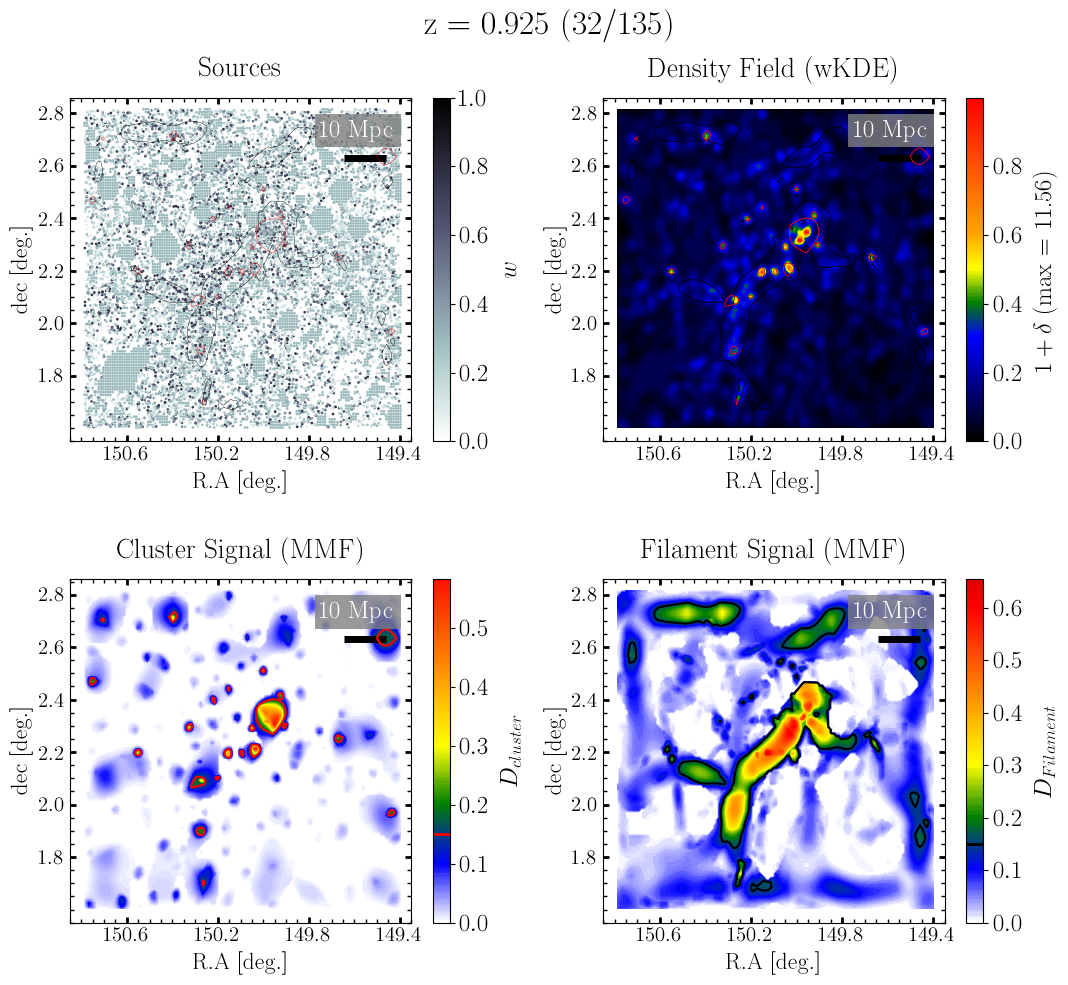

In [13]:
slice = redshift_slices[0]
gamma = 1

max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))

rows, columns = 2, 2
fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))

axlabelsize = 17
ticklabelsize = 15
markerSize = 3

title_size = 20
suptitle_size = 24
title_pad = 15

# Colorbars
cb_labelsize = 18
cb_tklabel_size = 3
cb_label_pad = 8

### Colormaps ###
points_cmap = plt.cm.get_cmap('bone_r')

# densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
densityMap_colors = [(0.0, 'black'), (0.3, 'blue'), (0.4, 'green'), (0.5, 'yellow'), (0.6, 'orange'), (1, 'red')]
cmap_densityMap = LinearSegmentedColormap.from_list('custom', densityMap_colors)
norm_densityMap = plt.Normalize(vmin=0, vmax=50) 

# Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
norm_cluster = plt.Normalize(vmin=0, vmax=1)
cmap_cluster = cmap_cluster_custom 

# Filament colorbar
filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
norm_filament = plt.Normalize(vmin=0, vmax=1) 
cmap_filament = cmap_filament_custom 

# Contours
cluster_signal_level = 0.15
filament_signal_level = 0.15
galaxies_contour_width = 0.3
density_contour_width = 0.6

scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

# Outline
mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
gr_y = np.linspace(delta_min, delta_max, mesh_y)
grid_x, grid_y = np.meshgrid(gr_x, gr_y)

for row in range(rows):
    for col in range(columns):
        ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
        ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
        ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
        ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
        ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
        ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
        ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
        ax[row, col].set_xlim(150.85, 149.35)
        ax[row, col].set_ylim(1.55, 2.86)
        ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
        ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
        ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
        ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
        ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
        ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
        ax[row, col].tick_params(which='major', width=2, length = 4)
        ax[row, col].tick_params(which='minor', width=1, length = 3)
        
# Galaxy Distribution
sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
cb0 = fig.colorbar(sc0, ax = ax[0, 0])
cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)

# Density Map
density_field = Slice(slice).density_excess / np.max(Slice(slice).density_excess)
vmin_density, vmax_density = np.min(density_field), np.max(density_field)
dn = ax[0, 1].contourf(grid_x, grid_y, density_field, 150, cmap = cmap_densityMap, norm = norm_densityMap, vmin = vmin_density, vmax = vmax_density)
ax[0, 1].set_title('Density Field (wKDE)', size = title_size, pad = title_pad)
cb1 = fig.colorbar(dn, ax = ax[0, 1])
cb1.set_ticks(np.round(np.arange(vmin_density, vmax_density, 0.2), 1))
cb1.set_label(r'$1+\delta$ (max = %.2f)' % np.max(Slice(slice).density_excess), size = cb_labelsize, labelpad = cb_label_pad)
ax[0, 1].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = density_contour_width)
ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = density_contour_width)

# Cluster Signal
cl = ax[1, 0].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
cb3 = fig.colorbar(cl, ax = ax[1, 0])
cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
ax[1, 0].set_title('Cluster Signal (MMF)', size = title_size, pad = title_pad)

# Filament Signal
fl = ax[1, 1].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
ax[1, 1].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
ax[1, 1].set_title('Filament Signal (MMF)', size = title_size, pad = title_pad)
cb4 = fig.colorbar(fl, ax = ax[1, 1])
cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

fig.set_facecolor('w')
fig.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)

plt.savefig(os.path.join(outputs_dir , 'plots/Filament-cluster-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)

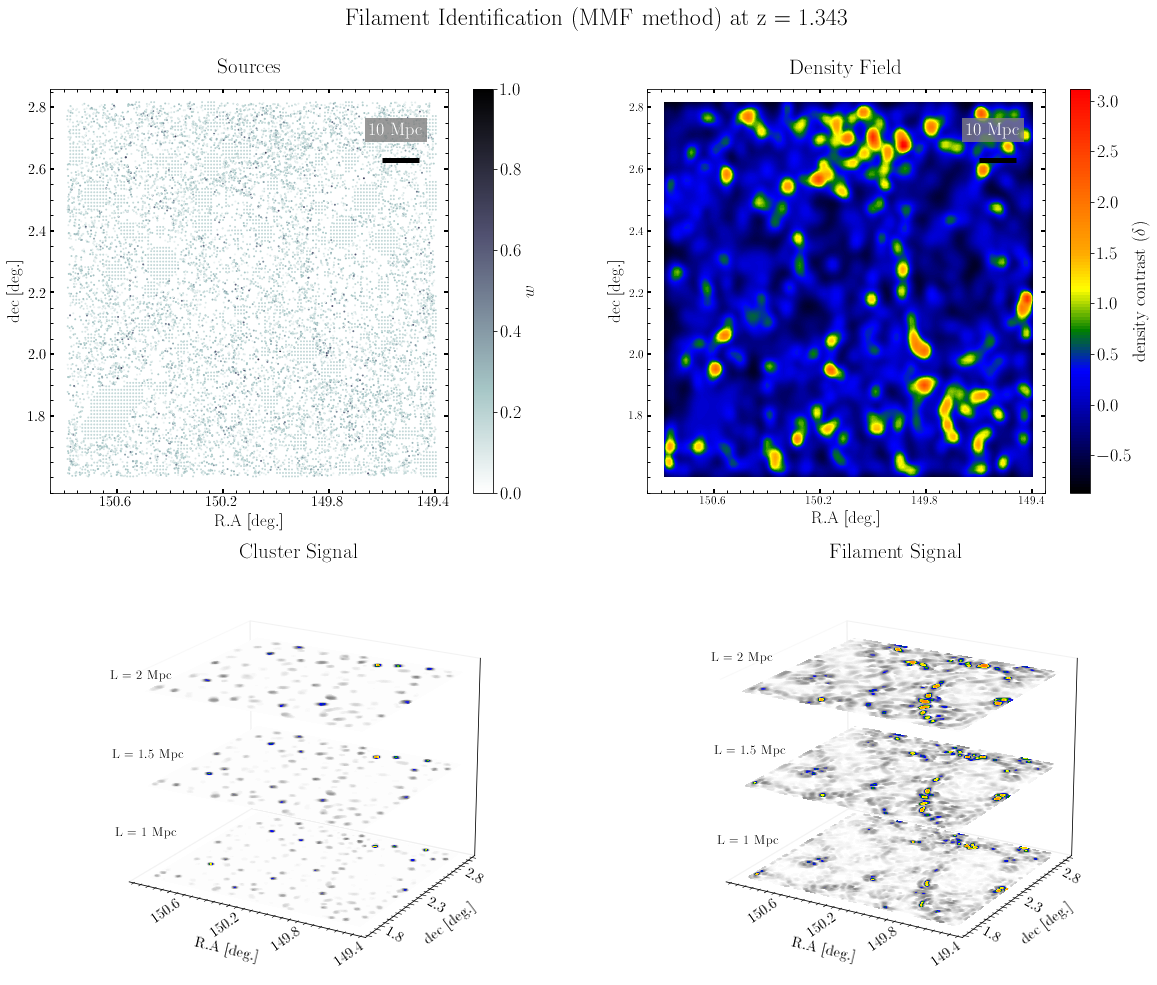

In [404]:
fig = plt.figure(figsize=(19, 19))

axlabelsize_f1 = 17
ticklabelsize = 15
titlesize_f1 = 21
cbarlabelsize_f1 = 18
markerSize = 3
title_pad_f1 = 15
cb_tklabel_size_f1 = 3
cb_label_pad_f1 = 0.002
scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

# cmap1 = plt.cm.get_cmap('bone_r')

mesh_y, mesh_x = np.shape(field)

gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
gr_y = np.linspace(delta_min, delta_max, mesh_y)

grid_x, grid_y = np.meshgrid(gr_x, gr_y)

ax1 = fig.add_subplot(221)
p1 = ax1.scatter(Slice(slice).sources[r'$\alpha$'], Slice(slice).sources[r'$\delta$'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = plt.cm.get_cmap('bone_r'))
cb1 = fig.colorbar(p1, ax = ax1)
cb1.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1], labelsize = cb_tklabel_size_f1)
cb1.set_label(r'$w$', size = cbarlabelsize_f1, labelpad = cb_label_pad_f1)
ax1.set_title('Sources', size = titlesize_f1, pad = title_pad_f1)
ax1.hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
ax1.text(149.65, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
ax1.set_xlabel('R.A [deg.]', size = axlabelsize_f1)
ax1.set_ylabel('dec [deg.]', size = axlabelsize_f1)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
ax1.set_xlim(150.85, 149.35)
ax1.set_ylim(1.55, 2.86)
ax1.set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
ax1.set_xticks([149.4, 149.8, 150.2, 150.6])
ax1.set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
ax1.set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
ax1.tick_params(which='major', width=2, length = 4)
ax1.tick_params(which='minor', width=1, length = 3)

vmin_density, vmax_density = np.min(Slice(slice).density_contrast), np.max(Slice(slice).density_contrast)
ax2 = fig.add_subplot(222)
p2 = ax2.contourf(grid_x, grid_y, Slice(slice).density_contrast, 150,cmap=cmap_densityMap, norm=norm_densityMap, vmin = vmin_density, vmax = vmax_density)
ax2.set_title('Density Field', size = titlesize_f1, pad = title_pad_f1)
cb2 = fig.colorbar(p2, ax = ax2)
cb2.set_ticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3], labelsize = cb_tklabel_size_f1)
cb2.set_label(r'density contrast ($\delta$)', size = cbarlabelsize_f1, labelpad = cb_label_pad_f1)
ax2.hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
ax2.text(149.65, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
ax2.set_xlabel('R.A [deg.]', size = axlabelsize_f1)
ax2.set_ylabel('dec [deg.]', size = axlabelsize_f1)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
ax2.set_xlim(150.85, 149.35)
ax2.set_ylim(1.55, 2.86)
ax2.set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
ax2.set_xticks([149.4, 149.8, 150.2, 150.6])
ax2.set_yticklabels(ax[row, col].get_yticks(), fontsize = 12)
ax2.set_xticklabels(ax[row, col].get_xticks(), fontsize = 12)
ax2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.tick_params(which='major', width=2, length = 4)
ax2.tick_params(which='minor', width=1, length = 3)


ax3 = fig.add_subplot(223, projection='3d')
ax3.view_init(elev=20, azim=-60)

surf3 = ax3.contourf(grid_x, grid_y, Signal_cluster5, zdir='z', offset=0.7, cmap=cmap_cluster, norm=norm_cluster, levels = 100)
ax3.contourf(grid_x, grid_y, Signal_cluster4, zdir='z', offset=0.35, cmap=cmap_cluster, norm=norm_cluster, levels = 100)
ax3.contourf(grid_x, grid_y, Signal_cluster3, zdir='z', offset=0, cmap=cmap_cluster, norm=norm_cluster, levels = 100)


ax3.set_title('Cluster Signal', size = titlesize_f1, pad = title_pad_f1)
ax3.set_xlabel('R.A [deg.]', size = 15, labelpad = 9)
ax3.set_ylabel('dec [deg.]', size = 15, labelpad = 3)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.set_xlim(150.85, 149.35)
ax3.set_ylim(1.55, 2.86)
ax3.set_yticks([1.8, 2.3, 2.8])
ax3.set_xticks([149.4, 149.8, 150.2, 150.6])
ax3.set_yticklabels(ax3.get_yticks(), fontsize = ticklabelsize, rotation = -30)
ax3.set_xticklabels(ax3.get_xticks(), fontsize = ticklabelsize, rotation = 35)
ax3.xaxis.set_minor_locator(MultipleLocator(0.05))
ax3.yaxis.set_minor_locator(MultipleLocator(0.05))
ax3.tick_params(which='major', width=2, length = 4)
ax3.tick_params(which='minor', width=1, length = 3)
ax3.text(151.1, 1.7, 0.7, 'L = 2 Mpc', size = 13, color = 'black')
ax3.text(151.1, 1.7, 0.4, 'L = 1.5 Mpc', size = 13, color = 'black')
ax3.text(151.1, 1.7, 0.1, 'L = 1 Mpc', size = 13, color = 'black')
ax3.tick_params(axis='x', pad=-5)
ax3.tick_params(axis='y', pad=-3)

ax3.xaxis.pane.fill = False
ax3.yaxis.pane.fill = False
ax3.zaxis.pane.fill = False
ax3.grid(False)
ax3.set_zticks([])

ax3.set_box_aspect([1.14, 1, 0.9])



ax4 = fig.add_subplot(224, projection='3d')
ax4.view_init(elev=20, azim=-60)

surf4 = ax4.contourf(grid_x, grid_y, Signal_filament5, zdir='z', offset=0.6, cmap=cmap_filament, norm=norm_filament, levels = 100)
ax4.contourf(grid_x, grid_y, Signal_filament4, zdir='z', offset=0.3, cmap=cmap_filament, norm=norm_filament, levels = 100)
ax4.contourf(grid_x, grid_y, Signal_filament3, zdir='z', offset=0, cmap=cmap_filament, norm=norm_filament, levels = 100)

ax4.set_title('Filament Signal', size = titlesize_f1, pad = title_pad_f1)
ax4.set_xlabel('R.A [deg.]', size = 15, labelpad = 9)
ax4.set_ylabel('dec [deg.]', size = 15, labelpad = 3)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.set_xlim(150.85, 149.35)
ax4.set_ylim(1.55, 2.86)
ax4.set_yticks([1.8, 2.3, 2.8])
ax4.set_xticks([149.4, 149.8, 150.2, 150.6])
ax4.set_yticklabels(ax4.get_yticks(), fontsize = ticklabelsize, rotation = -30)
ax4.set_xticklabels(ax4.get_xticks(), fontsize = ticklabelsize, rotation = 35)
ax4.xaxis.set_minor_locator(MultipleLocator(0.05))
ax4.yaxis.set_minor_locator(MultipleLocator(0.05))
ax4.tick_params(which='major', width=2, length = 4)
ax4.tick_params(which='minor', width=1, length = 3)
ax4.text(151.1, 1.75, 0.65, 'L = 2 Mpc', size = 13, color = 'black')
ax4.text(151.1, 1.75, 0.35, 'L = 1.5 Mpc', size = 13, color = 'black')
ax4.text(151.1, 1.75, 0.05, 'L = 1 Mpc', size = 13, color = 'black')
ax4.tick_params(axis='x', pad=-5)
ax4.tick_params(axis='y', pad=-3)

ax4.xaxis.pane.fill = False
ax4.yaxis.pane.fill = False
ax4.zaxis.pane.fill = False
ax4.grid(False)
ax4.set_zticks([])

ax4.set_box_aspect([1.14, 1, 0.9])

fig.set_facecolor('w')
fig.suptitle('Filament Identification (MMF method) at z = %.3f' %(slice_centers[slice]), family = 'Times New Roman', size= 24, y = 0.86)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.90, top=0.8, wspace=0.2) 


plt.savefig('results/Filament_identification_MultiScale.png', format = 'png', dpi = 300)